In [ ]:
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time

In [ ]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [ ]:
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

In [ ]:
!pip install facenet_pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 8.5 MB/s 


In [ ]:
# importing libraries

from facenet_pytorch import MTCNN, InceptionResnetV1, fixed_image_standardization, training
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, SubsetRandomSampler
from torch import optim
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.tensorboard import SummaryWriter
import numpy as np
from PIL import Image
import cv2
import time
import os

In [ ]:
data_dir = '/content/drive/MyDrive/photos'

batch_size = 32
epochs = 20
workers = 0 if os.name == 'nt' else 8

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

Running on device: cuda:0


In [ ]:
mtcnn = MTCNN(
    image_size=160, margin=0, min_face_size=20,
    thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True,
    device=device
)

In [ ]:
dataset = datasets.ImageFolder(data_dir, transform=transforms.Resize((512, 512)))
dataset.samples = [
    (p, p.replace(data_dir, data_dir + '_cropped'))
        for p, _ in dataset.samples
]
        
loader = DataLoader(
    dataset,
    num_workers=workers,
    batch_size=batch_size,
    collate_fn=training.collate_pil
)

for i, (x, y) in enumerate(loader):
    mtcnn(x, save_path=y)
    print('\rBatch {} of {}'.format(i + 1, len(loader)), end='')
    
# Remove mtcnn to reduce GPU memory usage
del mtcnn

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/facenet_pytorch/models/utils/detect_face.py:183: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  batch_boxes, batch_points = np.array(batch_boxes), np.array(batch_points)
/usr/local/lib/python3.7/dist-packages/facenet_pytorch/models/mtcnn.py:339: VisibleDeprecationWarning: Creating an

Batch 1 of 1

In [ ]:
!pip install face_recognition

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 100.1 MB 1.1 MB/s 
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566186 sha256=e23e88e50c54883ca5b1bf51b083ddbc9e21595203acdc768b6750268d23a956
  Stored in directory: /root/.cache/pip/wheels/d6/81/3c/884bcd5e1c120ff548d57c2ecc9ebf3281c9a6f7c0e7e7947a
Successfully built face-recognition-models


In [ ]:
import face_recognition
known_image = face_recognition.load_image_file("/content/drive/MyDrive/photos/tanishq/20220923_144914.jpg")
unknown_image = face_recognition.load_image_file("/content/drive/MyDrive/photos/suyash/20220923_145343.jpg")

biden_encoding = face_recognition.face_encodings(known_image)[0]
unknown_encoding = face_recognition.face_encodings(unknown_image)[0]

results = face_recognition.compare_faces([biden_encoding], unknown_encoding)

In [ ]:
results

[False]

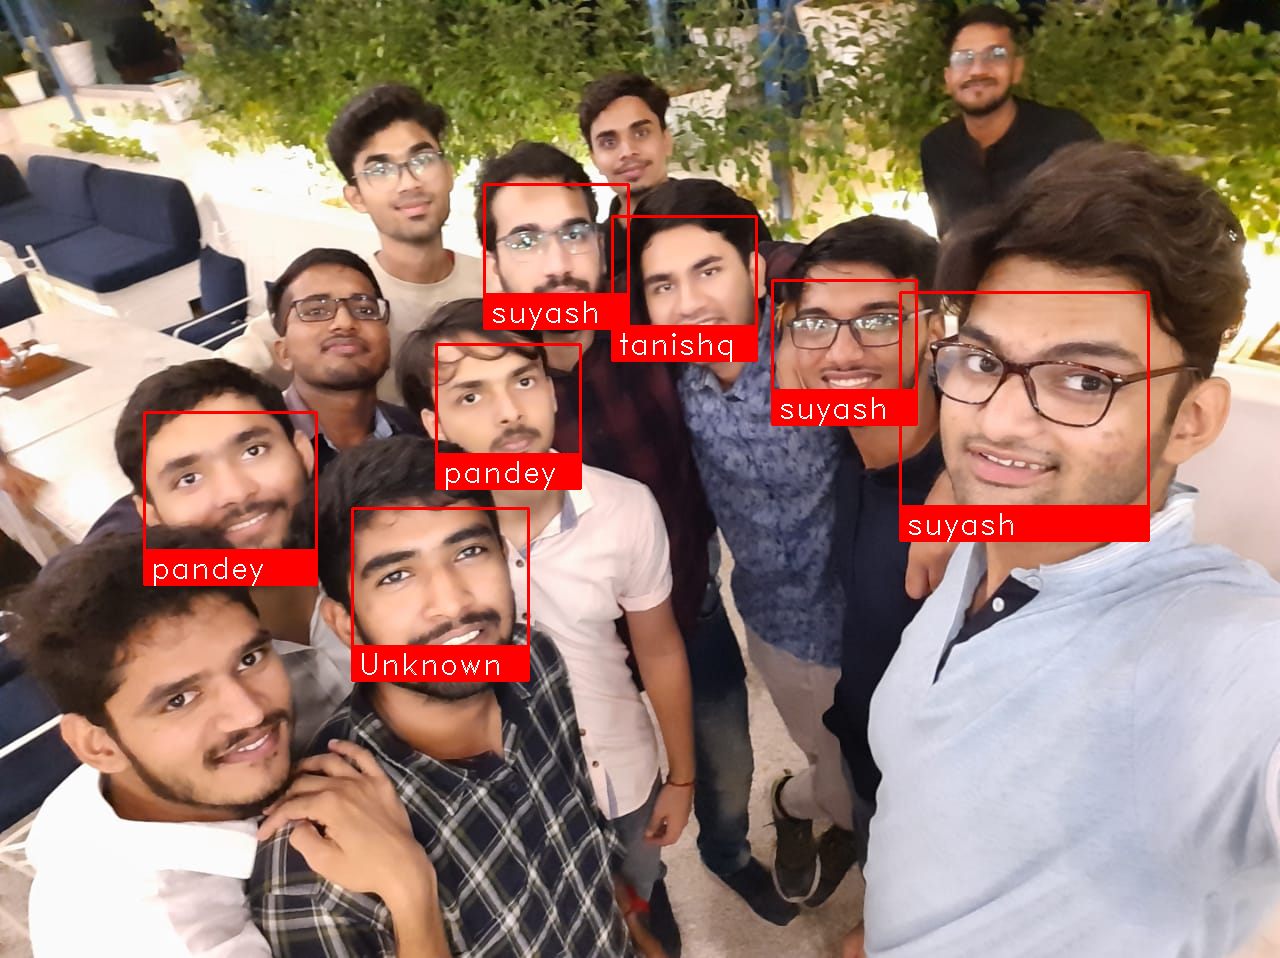

In [ ]:
import face_recognition
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
import os

path = "/content/drive/MyDrive/photos_cropped"

known_encodings = []
known_names = []

for f in os.listdir(path):
  newpath = path + "/" + f
  for g in os.listdir(newpath):
    finalpath = newpath + "/" + g
    image = face_recognition.load_image_file(finalpath)
    face_encoding = face_recognition.face_encodings(image)
    # print(face_encoding)
    if(len(face_encoding) > 0):
      known_encodings.append(face_encoding[0])
      known_names.append(f)

# frame = cv2.imread("test.jpg")
frame = cv2.imread("4.jpeg")

# cv2_imshow(frame)

# Initialize some variables
face_locations = []
face_encodings = []
face_names = []

small_frame = cv2.resize(frame, (0, 0), fx=0.25, fy=0.25)
rgb_small_frame = small_frame[:, :, ::-1]

face_locations = face_recognition.face_locations(rgb_small_frame)
face_encodings = face_recognition.face_encodings(rgb_small_frame, face_locations)

face_names = []

for face_encoding in face_encodings:
    # See if the face is a match for the known face(s)
    matches = face_recognition.compare_faces(known_encodings, face_encoding)
    name = "Unknown"

    face_distances = face_recognition.face_distance(known_encodings, face_encoding)
    best_match_index = np.argmin(face_distances)
    if matches[best_match_index]:
        name = known_names[best_match_index]

    face_names.append(name)

for (top, right, bottom, left), name in zip(face_locations, face_names):
    # Scale back up face locations since the frame we detected in was scaled to 1/4 size
    top *= 4
    right *= 4
    bottom *= 4
    left *= 4

    # Draw a box around the face
    cv2.rectangle(frame, (left, top), (right, bottom), (0, 0, 255), 2)

    # Draw a label with a name below the face
    cv2.rectangle(frame, (left, bottom - 35), (right, bottom), (0, 0, 255), cv2.FILLED)
    font = cv2.FONT_HERSHEY_DUPLEX
    cv2.putText(frame, name, (left + 6, bottom - 6), font, 1.0, (255, 255, 255), 1)

# Display the resulting image
cv2_imshow(frame)


In [2]:
# test code

# !pip install facenet_pytorch
from facenet_pytorch import MTCNN, InceptionResnetV1
from google.colab.patches import cv2_imshow
import cv2
import torchvision.transforms as transforms

resnet = InceptionResnetV1(pretrained='vggface2').eval()   
transform = transforms.ToTensor() 

image = cv2.imread('/content/20220923_144914.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
print(image.shape)
tensor = transform(image)

emb = resnet(tensor.unsqueeze(0))

# print(emb)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
(87, 118, 3)


In [ ]:
# import face_recognition


from facenet_pytorch import MTCNN, InceptionResnetV1

resnet = InceptionResnetV1(pretrained='vggface2').eval()    

mtcnn0 = MTCNN(image_size=240, margin=0, keep_all=False, min_face_size=40) # keep_all=False
mtcnn = MTCNN(image_size=240, margin=0, keep_all=True, min_face_size=40) # keep_all=True

import cv2
import numpy as np
from google.colab.patches import cv2_imshow
import os

# Read data from folder

dataset = datasets.ImageFolder('/content/drive/MyDrive/photos') # photos folder path 
idx_to_class = {i:c for c,i in dataset.class_to_idx.items()} # accessing names of peoples from folder names

def collate_fn(x):
    return x[0]

loader = DataLoader(dataset, collate_fn=collate_fn)

name_list = [] # list of names corrospoing to cropped photos
embedding_list = [] # list of embeding matrix after conversion from cropped faces to embedding matrix using resnet

for img, idx in loader:
    face, prob = mtcnn0(img, return_prob=True) 
    
    if face is not None and prob>0.92:
        emb = resnet(face.unsqueeze(0)) 
        embedding_list.append(emb.detach()) 
        name_list.append(idx_to_class[idx])        

# save data
data = [embedding_list, name_list] 
torch.save(data, 'data.pt') # saving data.pt file

# Using webcam recognize face
from google.colab.patches import cv2_imshow

# loading data.pt file
load_data = torch.load('data.pt') 
embedding_list = load_data[0] 
name_list = load_data[1] 

bbox = ''
count = 0 

from PIL import Image

frame = cv2.imread("4.jpeg")
img = Image.fromarray(frame)
img_cropped_list, prob_list = mtcnn(img, return_prob=True) 

if img_cropped_list is not None:
  boxes, _ = mtcnn.detect(img)
                
  for i, prob in enumerate(prob_list):
    if prob>0.90:
      emb = resnet(img_cropped_list[i].unsqueeze(0)).detach() 
                
      dist_list = [] # list of matched distances, minimum distance is used to identify the person
                
      for idx, emb_db in enumerate(embedding_list):
        dist = torch.dist(emb, emb_db).item()
        dist_list.append(dist)

      min_dist = min(dist_list) # get minumum dist value
      min_dist_idx = dist_list.index(min_dist) # get minumum dist index
      name = name_list[min_dist_idx] # get name corrosponding to minimum dist
                
      box = boxes[i] 
                
      original_frame = frame.copy() # storing copy of frame before drawing on it
                
      if min_dist<0.90:
        frame = cv2.putText(frame, name, (int(box[0]),int(box[1])), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0),1, cv2.LINE_AA)
                
      frame = cv2.rectangle(frame, (int(box[0]),int(box[1])) , (int(box[2]),int(box[3])), (255,0,0), 2)

cv2_imshow(frame)


AttributeError: ignored

In [ ]:
def initialize_recognition():
    data_dir = './photos'
    dataset = datasets.ImageFolder(data_dir)
    idx_to_class = {i:c for c,i in dataset.class_to_idx.items()}

    loader = DataLoader(dataset, collate_fn=collate_fn)

    
    resnet = InceptionResnetV1(pretrained='vggface2').eval()  
    face = face_analysis()  

    transform = transforms.ToTensor()

    name_list = []
    embedding_list = [] 

    for image, idx in loader:

        opencv_image = np.array(image)

        img, box, conf = face.face_detection(frame_arr=opencv_image, frame_status=False, model='tiny')
        print(img)
        for i in range(len(box)):
            cropped = opencv_image[int(box[i][1]):int(box[i][1])+int(box[i][3]), int(box[i][0]):int(box[i][0])+int(box[i][2]),:]
            tensor = transform(cropped)
            embedding = resnet(tensor.unsqueeze(0))
            embedding_list.append(embedding.detach())
            name_list.append(idx_to_class[idx])

    data = [embedding_list, name_list] 
    return data

In [ ]:
!pip install yoloface

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for yoloface: filename=yoloface-0.0.4-py3-none-any.whl size=5984 sha256=1fd2c1a1e07cc3a24e3a68cb5b60c3af038a14fa92a36973e93a42c68e452844
  Stored in directory: /root/.cache/pip/wheels/53/bd/2a/eb7a521c6b09e1710a7d4f712d9394b8b49ac9cbc0b2e4b5bb
Successfully built yoloface


In [ ]:
import os
import cv2
from yoloface import face_analysis

def crop_photos():
    folder = '/content/drive/MyDrive/photos'
    savefolder = 'cropped_photos'
    face = face_analysis()  

    for filename in os.listdir(folder):
        indfolder = folder + "/" + filename
        indsavefolder = savefolder + "/" + filename
        for fname in os.listdir(indfolder):
          opencv_image = cv2.imread(os.path.join(indfolder,fname))
          if opencv_image is not None:
            img, box, conf = face.face_detection(frame_arr=opencv_image, frame_status=False, model='tiny')
            for i in range(len(box)):
                cropped = opencv_image[int(box[i][0]):int(box[i][0])+int(box[i][3]), int(box[i][1]):int(box[i][1])+int(box[i][2])]
                name = filename
                if not os.path.exists(indsavefolder):
                  os.makedirs(indsavefolder)
                finalpath = indsavefolder + "/" + fname
                cv2.imwrite(finalpath, cropped)

crop_photos()

yolov3-tiny_face.weights:: status : file already exists
yolov3_tiny_face.cfg:: status : file already exists
face_detection.weights:: status : file already exists
face_detection.cfg:: status : file already exists
